In [187]:
import CalculatedFieldSubroutines as cfs

#

import numpy as np

import pandas as pd

import random

#

import matplotlib.pyplot as plt

import cartopy.crs as ccrs

from cartopy.io.img_tiles import OSM, GoogleTiles, StadiaMapsTiles, MapQuestOSM

from pandasgui import show

#

import warnings

#

from sklearn import tree

#

from itertools import permutations

In [188]:
def ML_metrics( confusion_matrix_values, display = False ):

    TP, TN, FP, FN = confusion_matrix_values

    #

    precision = TP / ( TP + FP )

    sensitivity = TP / ( TP + FN )

    specificity = TN / ( TN + FP )

    #

    accuracy = ( TP + TN ) / ( TP + TN + FP + FN )

    balanced_accuracy = ( sensitivity + specificity ) / 2

    if ( display == True ):

        print( f'True_Positives: { TP }, False_Positives: { FP }' )

        print( f'False_Negatives: { FN }, True_Negatives: { TN }' )

        print( '' )

        print( f'Precision: { precision:.3f}' )

        print( f'Sensitivity: { sensitivity:.3f}' )

        print( f'Specificity: { specificity:.3f}' )

        print( '' )

        print( f'Accuracy: { accuracy:.3f}' )

        print( f'Balanced_Accuracy: { balanced_accuracy:.3f}' )

    return TP, TN, FP, FN, precision, sensitivity, specificity, accuracy, balanced_accuracy

In [189]:
def unique_disengagement_accuracy( Y_pred, Y_test, test_DisengagementExpandedID_col, display = False ):

    temp_df = pd.DataFrame()

    #

    temp_df[ 'Y_pred' ] = list( Y_pred ) 

    temp_df[ 'Y_test' ] = list( Y_test )

    #

    temp_df[ 'DisengagementExpandedID' ] = list( test_DisengagementExpandedID_col )

    #

    temp_df = temp_df[ temp_df[ 'DisengagementExpandedID' ] != 'NAD' ]

    #

    DisengagementID_col = []

    for ExpandedID in temp_df[ 'DisengagementExpandedID' ]:

        index = ExpandedID.index( 'ED' )

        ID = ExpandedID[ : index - 1 ]

        DisengagementID_col.append( ID )

    temp_df[ 'DisengagementID' ] = DisengagementID_col

    #

    unique_DisengagementIDs_wCounts = dict( temp_df[ 'DisengagementID' ].value_counts() )

    num_of_unique_DisengagementIDs = len( unique_DisengagementIDs_wCounts.keys() )

    #

    temp_df = temp_df[ ( temp_df[ 'Y_pred'] == 1 ) & ( temp_df[ 'Y_test' ] == 1 ) ]

    #

    unique_TP_DisengagementIDs_wCounts = dict( temp_df[ 'DisengagementID' ].value_counts() )

    num_of_unique_TP_DisengagementIDs = len( unique_TP_DisengagementIDs_wCounts.keys() )

    #

    unique_disengagement_accu = num_of_unique_TP_DisengagementIDs / num_of_unique_DisengagementIDs

    #

    individual_disengagement_accuracies = {}

    for ID in unique_DisengagementIDs_wCounts.keys():

        current_disengagement_count = unique_DisengagementIDs_wCounts[ ID ]

        try:

            current_TP_disengagement_count = unique_TP_DisengagementIDs_wCounts[ ID ]

        except:

            current_TP_disengagement_count = 0

        individual_disengagement_accuracies[ ID ] = current_TP_disengagement_count / current_disengagement_count

    individual_disengagement_accuracies = dict( sorted( individual_disengagement_accuracies.items(), \
                                                        key = lambda item : item[ 1 ], reverse = True ) )

    #

    if ( display == True ):

        print( f'Unique Disengagement Accuracy: { unique_disengagement_accu:.3f}' )

        print( f'# of Unique Testing Disengagements w/ a True Positive: { num_of_unique_TP_DisengagementIDs }' )

        print( f'# of Unique Testing Disengagements: { num_of_unique_DisengagementIDs }' )

    #

    return unique_disengagement_accu, num_of_unique_TP_DisengagementIDs, num_of_unique_DisengagementIDs, \
           individual_disengagement_accuracies, unique_TP_DisengagementIDs_wCounts, unique_DisengagementIDs_wCounts

In [190]:
warnings.filterwarnings( 'ignore' )

In [191]:
gmID_list = cfs.list_whitelisted_gmIDs_with_traffic_data()

topic_list = cfs.list_topics()

print( topic_list )

['/apollo/canbus/chassis', '/apollo/drive/event', '/apollo/sensor/gnss/best/pose', '/apollo/perception/traffic/light']


In [192]:
# No Moving Average

In [193]:
moving_window = 10 # seconds

expansion_window = 1e9 # nanoseconds

#

red_preprocessed_dfs = []

green_preprocessed_dfs = []

blue_preprocessed_dfs = []

for gmID in gmID_list:

    preprocessed_df = cfs.retrieve_gmID_preprocessed_moving_data( gmID, window_seconds = moving_window )

    #

    cfs.BinaryDisengagementExpanded( preprocessed_df, moving_colname = 'time', window = expansion_window )

    #

    cfs.DisengagementID( preprocessed_df, expanded = False )

    cfs.DisengagementID( preprocessed_df, expanded = True )

    #

    preprocessed_df[ 'BinaryDisengagementExpanded' ] = preprocessed_df[ 'BinaryDisengagementExpanded' ].astype( str )

    #

    if ( cfs.give_route( gmID ) == 'Red' ):

        red_preprocessed_dfs.append( preprocessed_df )

    elif ( cfs.give_route( gmID ) == 'Green' ):

        green_preprocessed_dfs.append( preprocessed_df )

    elif ( cfs.give_route( gmID ) == 'Blue' ):

        blue_preprocessed_dfs.append( preprocessed_df )

In [194]:
# Simple Decision Tree Analysis

In [195]:
X_colnames = [ 'speedMps', 'brakePercentage', 'throttlePercentage', 'steeringPercentage', 'LatLonTotalStdDev', \
               'TernaryTurnSignal', 'BinaryContainLights' ]

y_colname = 'BinaryDisengagementExpanded'

In [196]:
red_df = pd.concat( red_preprocessed_dfs )

#

training_red_dfs, testing_red_dfs = cfs.random_list_split( red_preprocessed_dfs, split_percentage = 0.8 )

training_red_df = pd.concat( training_red_dfs )

testing_red_df = pd.concat( testing_red_dfs )

#

X_train_red = training_red_df[ X_colnames ]

y_train_red = training_red_df[ y_colname ]

#

X_test_red = testing_red_df[ X_colnames ]

y_test_red = testing_red_df[ y_colname ]

In [197]:
green_df = pd.concat( green_preprocessed_dfs )

#

training_green_dfs, testing_green_dfs = cfs.random_list_split( green_preprocessed_dfs, split_percentage = 0.8 )

training_green_df = pd.concat( training_green_dfs )

testing_green_df = pd.concat( testing_green_dfs )

#

X_train_green = training_green_df[ X_colnames ]

y_train_green = training_green_df[ y_colname ]

#

X_test_green = testing_green_df[ X_colnames ]

y_test_green = testing_green_df[ y_colname ]

In [198]:
blue_df = pd.concat( blue_preprocessed_dfs )

#

training_blue_dfs, testing_blue_dfs = cfs.random_list_split( blue_preprocessed_dfs, split_percentage = 0.8 )

training_blue_df = pd.concat( training_blue_dfs )

testing_blue_df = pd.concat( testing_blue_dfs )

#

X_train_blue = training_blue_df[ X_colnames ]

y_train_blue = training_blue_df[ y_colname ]

#

X_test_blue = testing_blue_df[ X_colnames ]

y_test_blue = testing_blue_df[ y_colname ]

In [199]:
# Red Route

In [200]:
# No Max Depth

In [201]:
model_dt_red = tree.DecisionTreeClassifier( random_state = 0 )

model_dt_red = model_dt_red.fit( X_train_red, y_train_red )

#

y_pred_train_red = model_dt_red.predict( X_train_red )

y_pred_test_red = model_dt_red.predict( X_test_red )

#

training_red_df[ 'pred_BinaryDisengagementExpanded' ] = y_pred_train_red

testing_red_df[ 'pred_BinaryDisengagementExpanded' ] = y_pred_test_red

In [202]:
print( 'ML Metrics | Red Route | Training Data (~80% of gmIDs) | No Max Tree Depth\n' )

metrics = ML_metrics( cfs.confusion_matrix_values( y_pred_train_red.astype( int ), 
                                                   y_train_red.astype( int ) ), 
                                                   display = True )

print( '' )

unique_disengagement_info = unique_disengagement_accuracy( y_pred_train_red.astype( int ), 
                                                           y_train_red.astype( int ), 
                                                           training_red_df[ 'DisengagementExpandedID' ], 
                                                           display = True )

ML Metrics | Red Route | Training Data (~80% of gmIDs) | No Max Tree Depth

True_Positives: 16709, False_Positives: 95
False_Negatives: 129, True_Negatives: 2886146

Precision: 0.994
Sensitivity: 0.992
Specificity: 1.000

Accuracy: 1.000
Balanced_Accuracy: 0.996

Unique Disengagement Accuracy: 1.000
# of Unique Testing Disengagements w/ a True Positive: 503
# of Unique Testing Disengagements: 503


In [203]:
print( 'ML Metrics | Red Route | Testing Data (~20% of gmIDs) | No Max Tree Depth\n' )

metrics = ML_metrics( cfs.confusion_matrix_values( y_pred_test_red.astype( int ), 
                                                   y_test_red.astype( int ) ), 
                                                   display = True )

print( '' )

unique_disengagement_info = unique_disengagement_accuracy( y_pred_test_red.astype( int ), 
                                                           y_test_red.astype( int ), 
                                                           testing_red_df[ 'DisengagementExpandedID' ], 
                                                           display = True )

ML Metrics | Red Route | Testing Data (~20% of gmIDs) | No Max Tree Depth

True_Positives: 358, False_Positives: 4906
False_Negatives: 3524, True_Negatives: 775690

Precision: 0.068
Sensitivity: 0.092
Specificity: 0.994

Accuracy: 0.989
Balanced_Accuracy: 0.543

Unique Disengagement Accuracy: 0.395
# of Unique Testing Disengagements w/ a True Positive: 47
# of Unique Testing Disengagements: 119


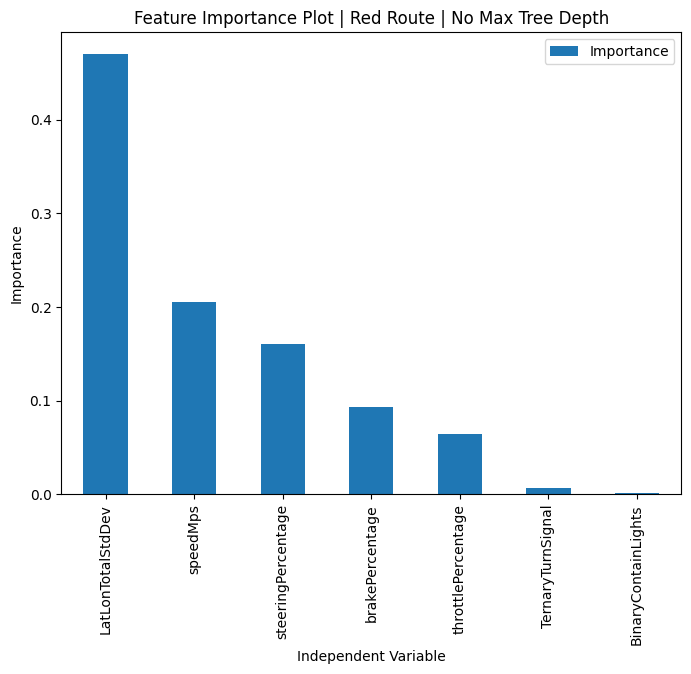

In [204]:
feat_importances = pd.DataFrame( model_dt_red.feature_importances_, index = X_train_red.columns, columns = [ "Importance" ] )

feat_importances.sort_values( by = 'Importance', ascending = False, inplace = True )

feat_importances.plot( kind = 'bar', figsize = ( 8, 6 ) )

plt.xlabel( 'Independent Variable' )

plt.ylabel( 'Importance' )

plt.title( 'Feature Importance Plot | Red Route | No Max Tree Depth' )

plt.show()

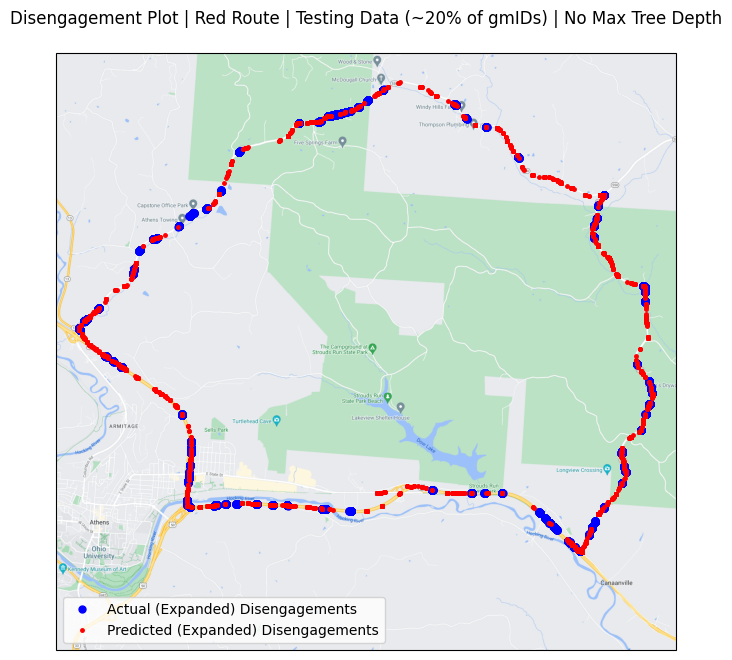

In [205]:
plt.figure( figsize = ( 8, 8 ) )

#

minLat = np.min( np.array( red_df[ 'latitude' ] ) )

maxLat = np.max( np.array( red_df[ 'latitude' ] ) )

minLon = np.min( np.array( red_df[ 'longitude' ] ) )

maxLon = np.max( np.array( red_df[ 'longitude' ] ) )

expansion_coeff = 0.005

#

street_map = GoogleTiles( style = 'street' )

ax = plt.axes( projection = street_map.crs )

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image(street_map, 14)

#

actual_disengagement_lat_list_test =  testing_red_df[ testing_red_df[ 'BinaryDisengagementExpanded' ] == '1' ][ 'latitude' ]

actual_disengagement_lon_list_test =  testing_red_df[ testing_red_df[ 'BinaryDisengagementExpanded' ] == '1' ][ 'longitude' ]

#

pred_disengagement_lat_list_test =  testing_red_df[ testing_red_df[ 'pred_BinaryDisengagementExpanded' ] == '1' ][ 'latitude' ]

pred_disengagement_lon_list_test =  testing_red_df[ testing_red_df[ 'pred_BinaryDisengagementExpanded' ] == '1' ][ 'longitude' ]

#

plt.plot( actual_disengagement_lon_list_test, 
          actual_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'blue',  
          ms = 5, 
          label = 'Actual (Expanded) Disengagements' )

plt.plot( pred_disengagement_lon_list_test, 
          pred_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'red', 
          ms = 2.5,
          label = 'Predicted (Expanded) Disengagements' )

plt.title( 'Disengagement Plot | Red Route | Testing Data (~20% of gmIDs) | No Max Tree Depth\n' )

plt.legend()

plt.show()

In [206]:
# Max Depth Applied

In [207]:
model_dt_red = tree.DecisionTreeClassifier( random_state = 0, max_depth = 10 )

model_dt_red = model_dt_red.fit( X_train_red, y_train_red )

#

y_pred_train_red = model_dt_red.predict( X_train_red )

y_pred_test_red = model_dt_red.predict( X_test_red )

#

training_red_df[ 'pred_BinaryDisengagementExpanded' ] = y_pred_train_red

testing_red_df[ 'pred_BinaryDisengagementExpanded' ] = y_pred_test_red

In [208]:
print( 'ML Metrics | Red Route | Training Data (~80% of gmIDs) | Max Tree Depth = 10\n' )

metrics = ML_metrics( cfs.confusion_matrix_values( y_pred_train_red.astype( int ), 
                                                   y_train_red.astype( int ) ), 
                                                   display = True )

print( '' )

unique_disengagement_info = unique_disengagement_accuracy( y_pred_train_red.astype( int ), 
                                                           y_train_red.astype( int ), 
                                                           training_red_df[ 'DisengagementExpandedID' ], 
                                                           display = True )

ML Metrics | Red Route | Training Data (~80% of gmIDs) | Max Tree Depth = 10

True_Positives: 1529, False_Positives: 58
False_Negatives: 15309, True_Negatives: 2886183

Precision: 0.963
Sensitivity: 0.091
Specificity: 1.000

Accuracy: 0.995
Balanced_Accuracy: 0.545

Unique Disengagement Accuracy: 0.280
# of Unique Testing Disengagements w/ a True Positive: 141
# of Unique Testing Disengagements: 503


In [209]:
print( 'ML Metrics | Red Route | Testing Data (~20% of gmIDs) | Max Tree Depth = 10\n' )

metrics = ML_metrics( cfs.confusion_matrix_values( y_pred_test_red.astype( int ), 
                                                   y_test_red.astype( int ) ), 
                                                   display = True )

print( '' )

unique_disengagement_info = unique_disengagement_accuracy( y_pred_test_red.astype( int ), 
                                                           y_test_red.astype( int ), 
                                                           testing_red_df[ 'DisengagementExpandedID' ], 
                                                           display = True )

ML Metrics | Red Route | Testing Data (~20% of gmIDs) | Max Tree Depth = 10

True_Positives: 232, False_Positives: 224
False_Negatives: 3650, True_Negatives: 780372

Precision: 0.509
Sensitivity: 0.060
Specificity: 1.000

Accuracy: 0.995
Balanced_Accuracy: 0.530

Unique Disengagement Accuracy: 0.227
# of Unique Testing Disengagements w/ a True Positive: 27
# of Unique Testing Disengagements: 119


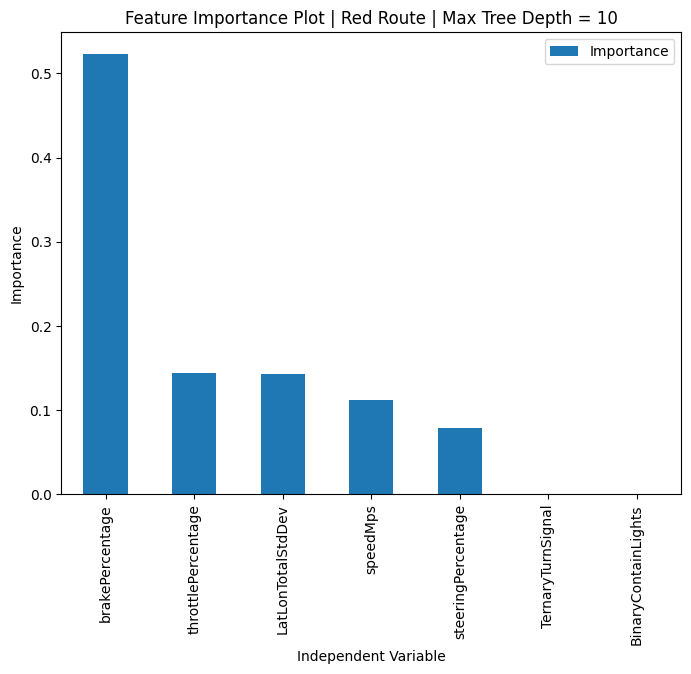

In [210]:
feat_importances = pd.DataFrame( model_dt_red.feature_importances_, index = X_train_red.columns, columns = [ "Importance" ] )

feat_importances.sort_values( by = 'Importance', ascending = False, inplace = True )

feat_importances.plot( kind = 'bar', figsize = ( 8, 6 ) )

plt.xlabel( 'Independent Variable' )

plt.ylabel( 'Importance' )

plt.title( 'Feature Importance Plot | Red Route | Max Tree Depth = 10' )

plt.show()

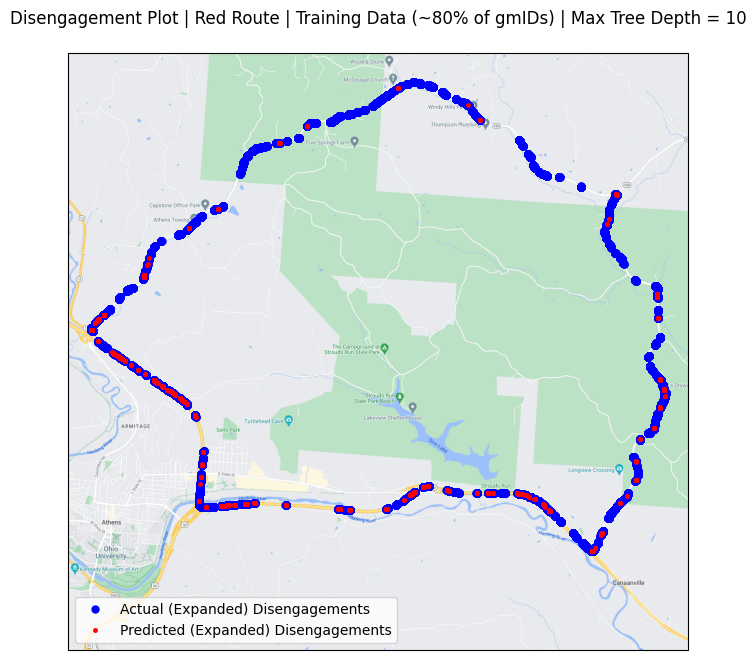

In [211]:
plt.figure( figsize = ( 8, 8 ) )

#

minLat = np.min( np.array( red_df[ 'latitude' ] ) )

maxLat = np.max( np.array( red_df[ 'latitude' ] ) )

minLon = np.min( np.array( red_df[ 'longitude' ] ) )

maxLon = np.max( np.array( red_df[ 'longitude' ] ) )

expansion_coeff = 0.005

#

street_map = GoogleTiles( style = 'street' )

ax = plt.axes( projection = street_map.crs )

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image(street_map, 14)

#

actual_disengagement_lat_list_test =  training_red_df[ training_red_df[ 'BinaryDisengagementExpanded' ] == '1' ][ 'latitude' ]

actual_disengagement_lon_list_test =  training_red_df[ training_red_df[ 'BinaryDisengagementExpanded' ] == '1' ][ 'longitude' ]

#

pred_disengagement_lat_list_test =  training_red_df[ training_red_df[ 'pred_BinaryDisengagementExpanded' ] == '1' ][ 'latitude' ]

pred_disengagement_lon_list_test =  training_red_df[ training_red_df[ 'pred_BinaryDisengagementExpanded' ] == '1' ][ 'longitude' ]

#

plt.plot( actual_disengagement_lon_list_test, 
          actual_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'blue',  
          ms = 5, 
          label = 'Actual (Expanded) Disengagements' )

plt.plot( pred_disengagement_lon_list_test, 
          pred_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'red', 
          ms = 2.5,
          label = 'Predicted (Expanded) Disengagements' )

plt.title( 'Disengagement Plot | Red Route | Training Data (~80% of gmIDs) | Max Tree Depth = 10\n' )

plt.legend()

plt.show()

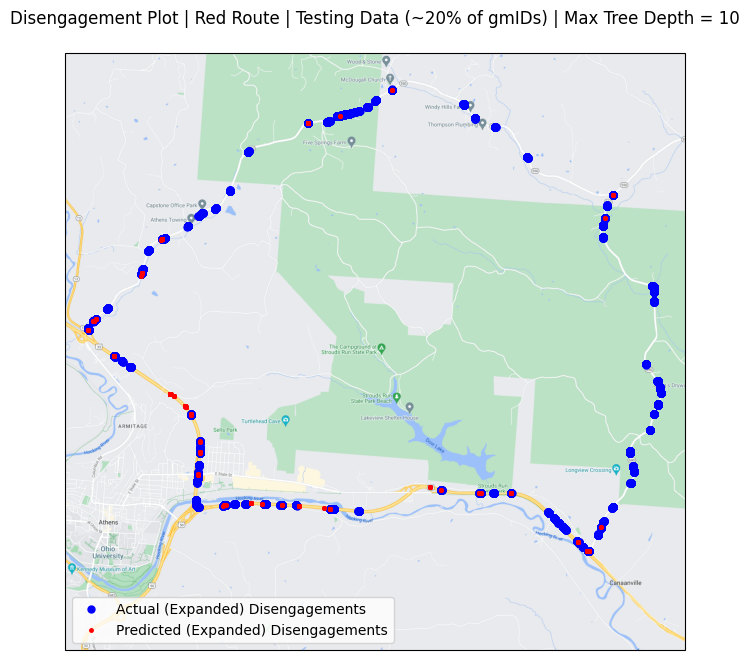

In [212]:
plt.figure( figsize = ( 8, 8 ) )

#

minLat = np.min( np.array( red_df[ 'latitude' ] ) )

maxLat = np.max( np.array( red_df[ 'latitude' ] ) )

minLon = np.min( np.array( red_df[ 'longitude' ] ) )

maxLon = np.max( np.array( red_df[ 'longitude' ] ) )

expansion_coeff = 0.005

#

street_map = GoogleTiles( style = 'street' )

ax = plt.axes( projection = street_map.crs )

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image(street_map, 14)

#

actual_disengagement_lat_list_test =  testing_red_df[ testing_red_df[ 'BinaryDisengagementExpanded' ] == '1' ][ 'latitude' ]

actual_disengagement_lon_list_test =  testing_red_df[ testing_red_df[ 'BinaryDisengagementExpanded' ] == '1' ][ 'longitude' ]

#

pred_disengagement_lat_list_test =  testing_red_df[ testing_red_df[ 'pred_BinaryDisengagementExpanded' ] == '1' ][ 'latitude' ]

pred_disengagement_lon_list_test =  testing_red_df[ testing_red_df[ 'pred_BinaryDisengagementExpanded' ] == '1' ][ 'longitude' ]

#

plt.plot( actual_disengagement_lon_list_test, 
          actual_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'blue',  
          ms = 5, 
          label = 'Actual (Expanded) Disengagements' )

plt.plot( pred_disengagement_lon_list_test, 
          pred_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'red', 
          ms = 2.5,
          label = 'Predicted (Expanded) Disengagements' )

plt.title( 'Disengagement Plot | Red Route | Testing Data (~20% of gmIDs) | Max Tree Depth = 10\n' )

plt.legend()

plt.show()

In [213]:
# Green Route

In [214]:
# No Max Depth

In [215]:
model_dt_green = tree.DecisionTreeClassifier( random_state = 0 )

model_dt_green = model_dt_green.fit( X_train_green, y_train_green )

#

y_pred_train_green = model_dt_green.predict( X_train_green )

y_pred_test_green = model_dt_green.predict( X_test_green )

#

training_green_df[ 'pred_BinaryDisengagementExpanded' ] = y_pred_train_green

testing_green_df[ 'pred_BinaryDisengagementExpanded' ] = y_pred_test_green

In [216]:
print( 'ML Metrics | Green Route | Training Data (~80% of gmIDs) | No Max Tree Depth\n' )

metrics = ML_metrics( cfs.confusion_matrix_values( y_pred_train_green.astype( int ), 
                                                   y_train_green.astype( int ) ), 
                                                   display = True )

print( '' )

unique_disengagement_info = unique_disengagement_accuracy( y_pred_train_green.astype( int ), 
                                                           y_train_green.astype( int ), 
                                                           training_green_df[ 'DisengagementExpandedID' ], 
                                                           display = True )

ML Metrics | Green Route | Training Data (~80% of gmIDs) | No Max Tree Depth

True_Positives: 9862, False_Positives: 41
False_Negatives: 122, True_Negatives: 1767578

Precision: 0.996
Sensitivity: 0.988
Specificity: 1.000

Accuracy: 1.000
Balanced_Accuracy: 0.994

Unique Disengagement Accuracy: 1.000
# of Unique Testing Disengagements w/ a True Positive: 300
# of Unique Testing Disengagements: 300


In [217]:
print( 'ML Metrics | Green Route | Testing Data (~20% of gmIDs) | No Max Tree Depth\n' )

metrics = ML_metrics( cfs.confusion_matrix_values( y_pred_test_green.astype( int ), 
                                                   y_test_green.astype( int ) ), 
                                                   display = True )

print( '' )

unique_disengagement_info = unique_disengagement_accuracy( y_pred_test_green.astype( int ), 
                                                           y_test_green.astype( int ), 
                                                           testing_green_df[ 'DisengagementExpandedID' ], 
                                                           display = True )

ML Metrics | Green Route | Testing Data (~20% of gmIDs) | No Max Tree Depth

True_Positives: 327, False_Positives: 2882
False_Negatives: 1935, True_Negatives: 394646

Precision: 0.102
Sensitivity: 0.145
Specificity: 0.993

Accuracy: 0.988
Balanced_Accuracy: 0.569

Unique Disengagement Accuracy: 0.397
# of Unique Testing Disengagements w/ a True Positive: 29
# of Unique Testing Disengagements: 73


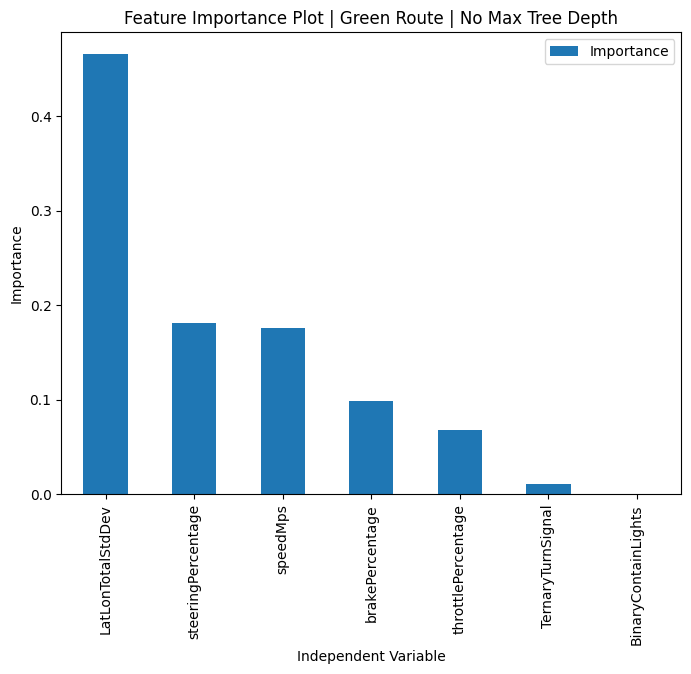

In [218]:
feat_importances = pd.DataFrame( model_dt_green.feature_importances_, index = X_train_green.columns, columns = [ "Importance" ] )

feat_importances.sort_values( by = 'Importance', ascending = False, inplace = True )

feat_importances.plot( kind = 'bar', figsize = ( 8, 6 ) )

plt.xlabel( 'Independent Variable' )

plt.ylabel( 'Importance' )

plt.title( 'Feature Importance Plot | Green Route | No Max Tree Depth' )

plt.show()

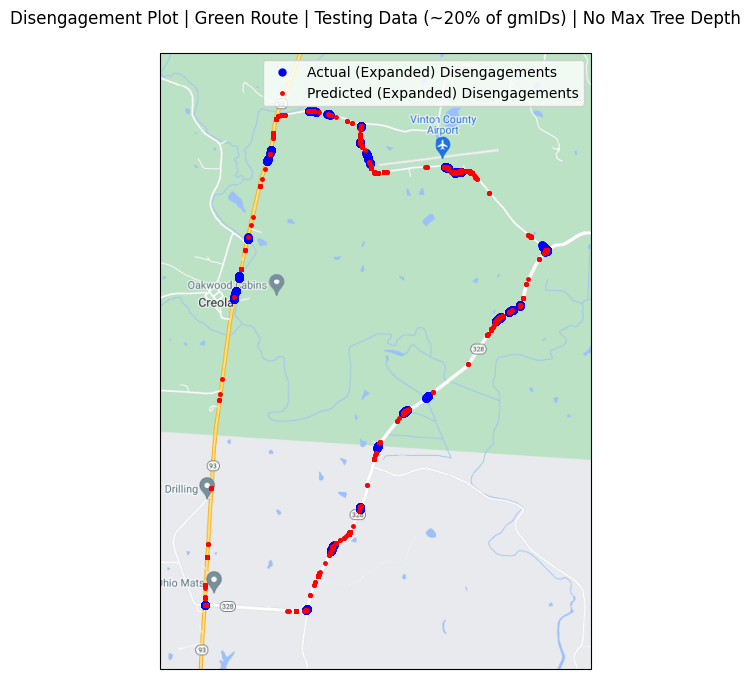

In [219]:
plt.figure( figsize = ( 8, 8 ) )

#

minLat = np.min( np.array( green_df[ 'latitude' ] ) )

maxLat = np.max( np.array( green_df[ 'latitude' ] ) )

minLon = np.min( np.array( green_df[ 'longitude' ] ) )

maxLon = np.max( np.array( green_df[ 'longitude' ] ) )

expansion_coeff = 0.005

#

street_map = GoogleTiles( style = 'street' )

ax = plt.axes( projection = street_map.crs )

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image(street_map, 14)

#

actual_disengagement_lat_list_test =  testing_green_df[ testing_green_df[ 'BinaryDisengagementExpanded' ] == '1' ][ 'latitude' ]

actual_disengagement_lon_list_test =  testing_green_df[ testing_green_df[ 'BinaryDisengagementExpanded' ] == '1' ][ 'longitude' ]

#

pred_disengagement_lat_list_test =  testing_green_df[ testing_green_df[ 'pred_BinaryDisengagementExpanded' ] == '1' ][ 'latitude' ]

pred_disengagement_lon_list_test =  testing_green_df[ testing_green_df[ 'pred_BinaryDisengagementExpanded' ] == '1' ][ 'longitude' ]

#

plt.plot( actual_disengagement_lon_list_test, 
          actual_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'blue',  
          ms = 5, 
          label = 'Actual (Expanded) Disengagements' )

plt.plot( pred_disengagement_lon_list_test, 
          pred_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'red', 
          ms = 2.5,
          label = 'Predicted (Expanded) Disengagements' )

plt.title( 'Disengagement Plot | Green Route | Testing Data (~20% of gmIDs) | No Max Tree Depth\n' )

plt.legend()

plt.show()

In [220]:
# Max Depth Applied

In [221]:
model_dt_green = tree.DecisionTreeClassifier( random_state = 0, max_depth = 10 )

model_dt_green = model_dt_green.fit( X_train_green, y_train_green )

#

y_pred_train_green = model_dt_green.predict( X_train_green )

y_pred_test_green = model_dt_green.predict( X_test_green )

#

training_green_df[ 'pred_BinaryDisengagementExpanded' ] = y_pred_train_green

testing_green_df[ 'pred_BinaryDisengagementExpanded' ] = y_pred_test_green

In [222]:
print( 'ML Metrics | Green Route | Training Data (~80% of gmIDs) | Max Tree Depth = 10\n' )

metrics = ML_metrics( cfs.confusion_matrix_values( y_pred_train_green.astype( int ), 
                                                   y_train_green.astype( int ) ), 
                                                   display = True )

print( '' )

unique_disengagement_info = unique_disengagement_accuracy( y_pred_train_green.astype( int ), 
                                                           y_train_green.astype( int ), 
                                                           training_green_df[ 'DisengagementExpandedID' ], 
                                                           display = True )

ML Metrics | Green Route | Training Data (~80% of gmIDs) | Max Tree Depth = 10

True_Positives: 2094, False_Positives: 338
False_Negatives: 7890, True_Negatives: 1767281

Precision: 0.861
Sensitivity: 0.210
Specificity: 1.000

Accuracy: 0.995
Balanced_Accuracy: 0.605

Unique Disengagement Accuracy: 0.420
# of Unique Testing Disengagements w/ a True Positive: 126
# of Unique Testing Disengagements: 300


In [223]:
print( 'ML Metrics | Green Route | Testing Data (~20% of gmIDs) | Max Tree Depth = 10\n' )

metrics = ML_metrics( cfs.confusion_matrix_values( y_pred_test_green.astype( int ), 
                                                   y_test_green.astype( int ) ), 
                                                   display = True )

print( '' )

unique_disengagement_info = unique_disengagement_accuracy( y_pred_test_green.astype( int ), 
                                                           y_test_green.astype( int ), 
                                                           testing_green_df[ 'DisengagementExpandedID' ], 
                                                           display = True )

ML Metrics | Green Route | Testing Data (~20% of gmIDs) | Max Tree Depth = 10

True_Positives: 145, False_Positives: 311
False_Negatives: 2117, True_Negatives: 397217

Precision: 0.318
Sensitivity: 0.064
Specificity: 0.999

Accuracy: 0.994
Balanced_Accuracy: 0.532

Unique Disengagement Accuracy: 0.164
# of Unique Testing Disengagements w/ a True Positive: 12
# of Unique Testing Disengagements: 73


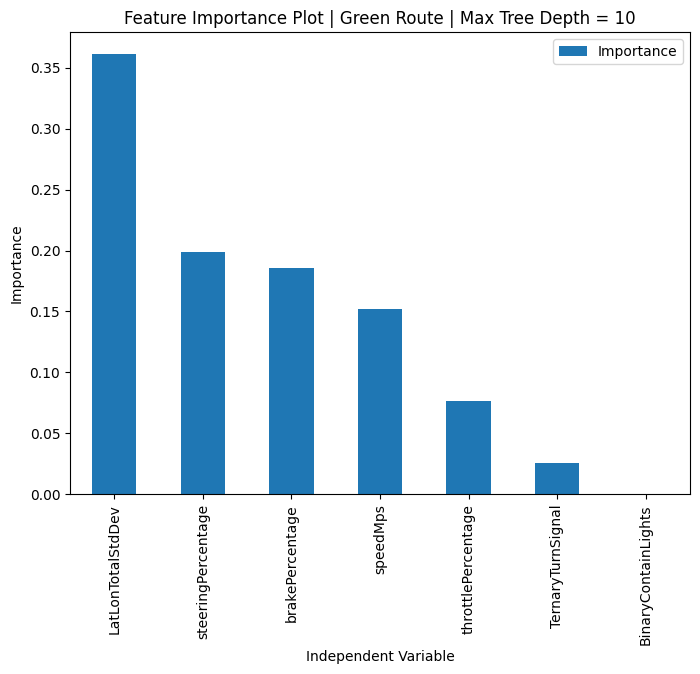

In [224]:
feat_importances = pd.DataFrame( model_dt_green.feature_importances_, index = X_train_green.columns, columns = [ "Importance" ] )

feat_importances.sort_values( by = 'Importance', ascending = False, inplace = True )

feat_importances.plot( kind = 'bar', figsize = ( 8, 6 ) )

plt.xlabel( 'Independent Variable' )

plt.ylabel( 'Importance' )

plt.title( 'Feature Importance Plot | Green Route | Max Tree Depth = 10' )

plt.show()

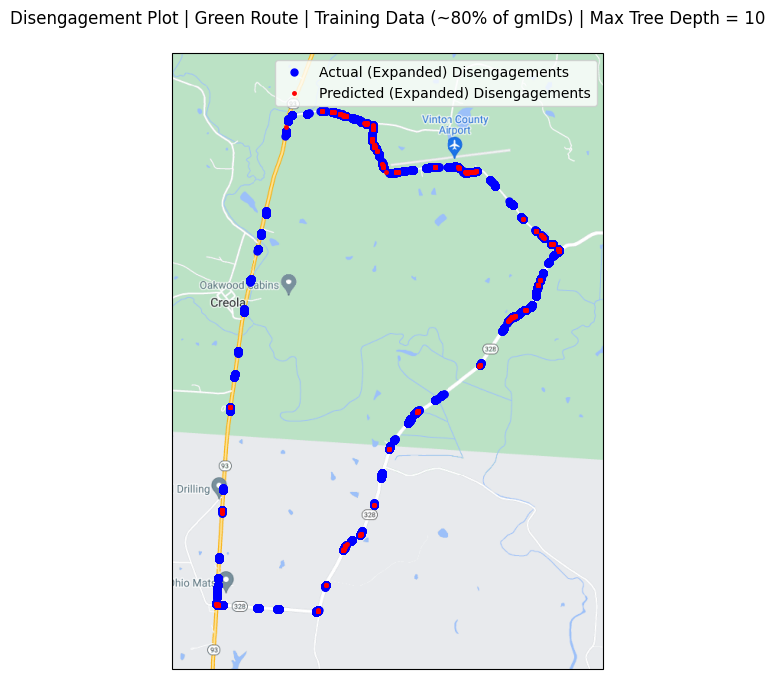

In [225]:
plt.figure( figsize = ( 8, 8 ) )

#

minLat = np.min( np.array( green_df[ 'latitude' ] ) )

maxLat = np.max( np.array( green_df[ 'latitude' ] ) )

minLon = np.min( np.array( green_df[ 'longitude' ] ) )

maxLon = np.max( np.array( green_df[ 'longitude' ] ) )

expansion_coeff = 0.005

#

street_map = GoogleTiles( style = 'street' )

ax = plt.axes( projection = street_map.crs )

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image(street_map, 14)

#

actual_disengagement_lat_list_test =  training_green_df[ training_green_df[ 'BinaryDisengagementExpanded' ] == '1' ][ 'latitude' ]

actual_disengagement_lon_list_test =  training_green_df[ training_green_df[ 'BinaryDisengagementExpanded' ] == '1' ][ 'longitude' ]

#

pred_disengagement_lat_list_test =  training_green_df[ training_green_df[ 'pred_BinaryDisengagementExpanded' ] == '1' ][ 'latitude' ]

pred_disengagement_lon_list_test =  training_green_df[ training_green_df[ 'pred_BinaryDisengagementExpanded' ] == '1' ][ 'longitude' ]

#

plt.plot( actual_disengagement_lon_list_test, 
          actual_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'blue',  
          ms = 5, 
          label = 'Actual (Expanded) Disengagements' )

plt.plot( pred_disengagement_lon_list_test, 
          pred_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'red', 
          ms = 2.5,
          label = 'Predicted (Expanded) Disengagements' )

plt.title( 'Disengagement Plot | Green Route | Training Data (~80% of gmIDs) | Max Tree Depth = 10\n' )

plt.legend()

plt.show()

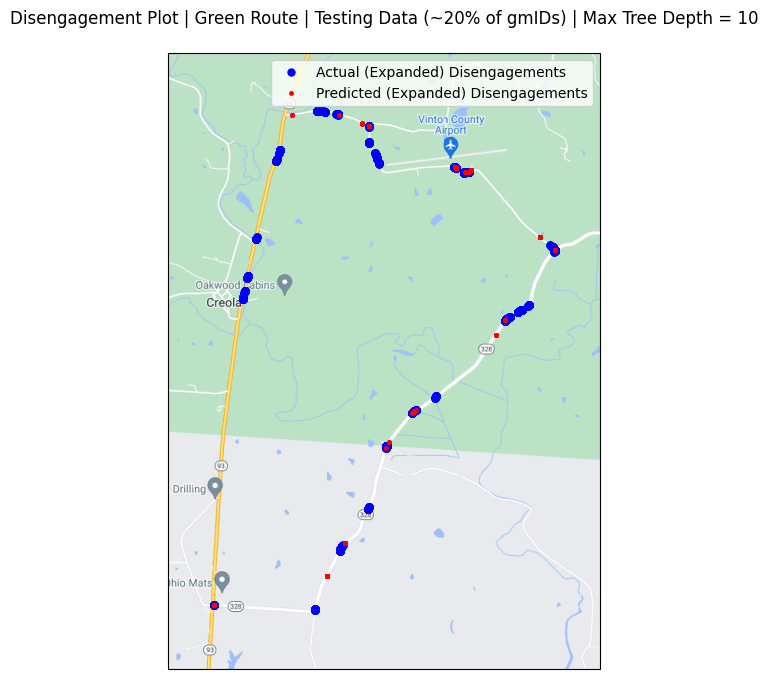

In [226]:
plt.figure( figsize = ( 8, 8 ) )

#

minLat = np.min( np.array( green_df[ 'latitude' ] ) )

maxLat = np.max( np.array( green_df[ 'latitude' ] ) )

minLon = np.min( np.array( green_df[ 'longitude' ] ) )

maxLon = np.max( np.array( green_df[ 'longitude' ] ) )

expansion_coeff = 0.005

#

street_map = GoogleTiles( style = 'street' )

ax = plt.axes( projection = street_map.crs )

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image(street_map, 14)

#

actual_disengagement_lat_list_test =  testing_green_df[ testing_green_df[ 'BinaryDisengagementExpanded' ] == '1' ][ 'latitude' ]

actual_disengagement_lon_list_test =  testing_green_df[ testing_green_df[ 'BinaryDisengagementExpanded' ] == '1' ][ 'longitude' ]

#

pred_disengagement_lat_list_test =  testing_green_df[ testing_green_df[ 'pred_BinaryDisengagementExpanded' ] == '1' ][ 'latitude' ]

pred_disengagement_lon_list_test =  testing_green_df[ testing_green_df[ 'pred_BinaryDisengagementExpanded' ] == '1' ][ 'longitude' ]

#

plt.plot( actual_disengagement_lon_list_test, 
          actual_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'blue',  
          ms = 5, 
          label = 'Actual (Expanded) Disengagements' )

plt.plot( pred_disengagement_lon_list_test, 
          pred_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'red', 
          ms = 2.5,
          label = 'Predicted (Expanded) Disengagements' )

plt.title( 'Disengagement Plot | Green Route | Testing Data (~20% of gmIDs) | Max Tree Depth = 10\n' )

plt.legend()

plt.show()

In [227]:
# Blue Route

In [228]:
# No Max Depth

In [229]:
model_dt_blue = tree.DecisionTreeClassifier( random_state = 0 )

model_dt_blue = model_dt_blue.fit( X_train_blue, y_train_blue )

#

y_pred_train_blue = model_dt_blue.predict( X_train_blue )

y_pred_test_blue = model_dt_blue.predict( X_test_blue )

#

training_blue_df[ 'pred_BinaryDisengagementExpanded' ] = y_pred_train_blue

testing_blue_df[ 'pred_BinaryDisengagementExpanded' ] = y_pred_test_blue

In [230]:
print( 'ML Metrics | Blue Route | Training Data (~80% of gmIDs) | No Max Tree Depth\n' )

metrics = ML_metrics( cfs.confusion_matrix_values( y_pred_train_blue.astype( int ), 
                                                   y_train_blue.astype( int ) ), 
                                                   display = True )

print( '' )

unique_disengagement_info = unique_disengagement_accuracy( y_pred_train_blue.astype( int ), 
                                                           y_train_blue.astype( int ), 
                                                           training_blue_df[ 'DisengagementExpandedID' ], 
                                                           display = True )

ML Metrics | Blue Route | Training Data (~80% of gmIDs) | No Max Tree Depth

True_Positives: 30670, False_Positives: 140
False_Negatives: 280, True_Negatives: 4289702

Precision: 0.995
Sensitivity: 0.991
Specificity: 1.000

Accuracy: 1.000
Balanced_Accuracy: 0.995

Unique Disengagement Accuracy: 1.000
# of Unique Testing Disengagements w/ a True Positive: 937
# of Unique Testing Disengagements: 937


In [231]:
print( 'ML Metrics | Blue Route | Testing Data (~20% of gmIDs) | No Max Tree Depth\n' )

metrics = ML_metrics( cfs.confusion_matrix_values( y_pred_test_blue.astype( int ), 
                                                   y_test_blue.astype( int ) ), 
                                                   display = True )

print( '' )

unique_disengagement_info = unique_disengagement_accuracy( y_pred_test_blue.astype( int ), 
                                                           y_test_blue.astype( int ), 
                                                           testing_blue_df[ 'DisengagementExpandedID' ], 
                                                           display = True )

ML Metrics | Blue Route | Testing Data (~20% of gmIDs) | No Max Tree Depth

True_Positives: 1515, False_Positives: 10527
False_Negatives: 6640, True_Negatives: 1098209

Precision: 0.126
Sensitivity: 0.186
Specificity: 0.991

Accuracy: 0.985
Balanced_Accuracy: 0.588

Unique Disengagement Accuracy: 0.663
# of Unique Testing Disengagements w/ a True Positive: 167
# of Unique Testing Disengagements: 252


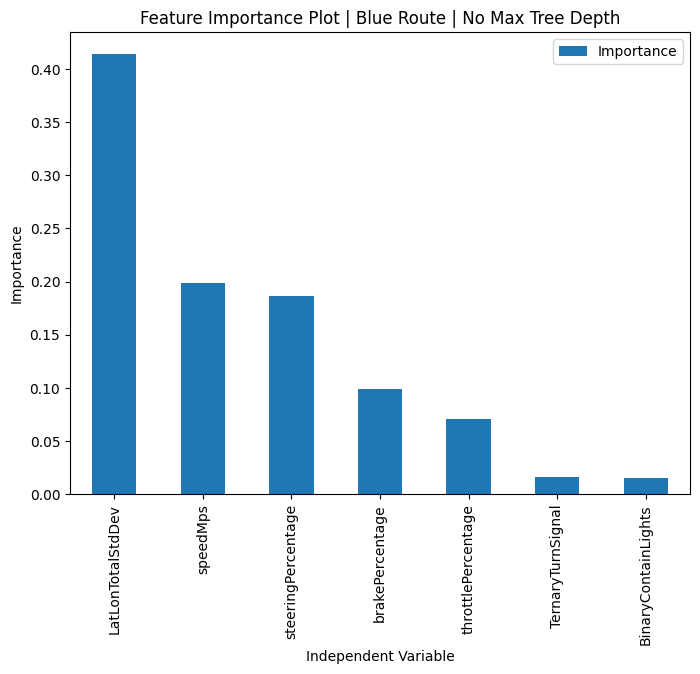

In [232]:
feat_importances = pd.DataFrame( model_dt_blue.feature_importances_, index = X_train_blue.columns, columns = [ "Importance" ] )

feat_importances.sort_values( by = 'Importance', ascending = False, inplace = True )

feat_importances.plot( kind = 'bar', figsize = ( 8, 6 ) )

plt.xlabel( 'Independent Variable' )

plt.ylabel( 'Importance' )

plt.title( 'Feature Importance Plot | Blue Route | No Max Tree Depth' )

plt.show()

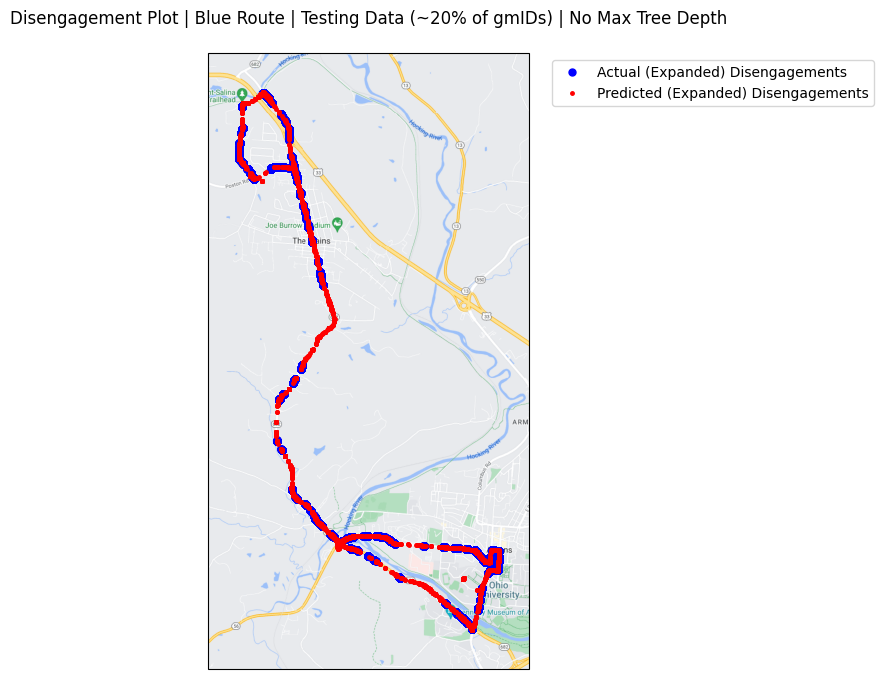

In [233]:
plt.figure( figsize = ( 8, 8 ) )

#

minLat = np.min( np.array( blue_df[ 'latitude' ] ) )

maxLat = np.max( np.array( blue_df[ 'latitude' ] ) )

minLon = np.min( np.array( blue_df[ 'longitude' ] ) )

maxLon = np.max( np.array( blue_df[ 'longitude' ] ) )

expansion_coeff = 0.005

#

street_map = GoogleTiles( style = 'street' )

ax = plt.axes( projection = street_map.crs )

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image(street_map, 14)

#

actual_disengagement_lat_list_test =  testing_blue_df[ testing_blue_df[ 'BinaryDisengagementExpanded' ] == '1' ][ 'latitude' ]

actual_disengagement_lon_list_test =  testing_blue_df[ testing_blue_df[ 'BinaryDisengagementExpanded' ] == '1' ][ 'longitude' ]

#

pred_disengagement_lat_list_test =  testing_blue_df[ testing_blue_df[ 'pred_BinaryDisengagementExpanded' ] == '1' ][ 'latitude' ]

pred_disengagement_lon_list_test =  testing_blue_df[ testing_blue_df[ 'pred_BinaryDisengagementExpanded' ] == '1' ][ 'longitude' ]

#

plt.plot( actual_disengagement_lon_list_test, 
          actual_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'blue',  
          ms = 5, 
          label = 'Actual (Expanded) Disengagements' )

plt.plot( pred_disengagement_lon_list_test, 
          pred_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'red', 
          ms = 2.5,
          label = 'Predicted (Expanded) Disengagements' )

plt.title( 'Disengagement Plot | Blue Route | Testing Data (~20% of gmIDs) | No Max Tree Depth\n' )

plt.legend( bbox_to_anchor = ( 1.05, 1.0 ), loc = 'upper left' )

plt.show()

In [234]:
# Max Depth Applied

In [235]:
model_dt_blue = tree.DecisionTreeClassifier( random_state = 0, max_depth = 10 )

model_dt_blue = model_dt_blue.fit( X_train_blue, y_train_blue )

#

y_pred_train_blue = model_dt_blue.predict( X_train_blue )

y_pred_test_blue = model_dt_blue.predict( X_test_blue )

#

training_blue_df[ 'pred_BinaryDisengagementExpanded' ] = y_pred_train_blue

testing_blue_df[ 'pred_BinaryDisengagementExpanded' ] = y_pred_test_blue

In [236]:
print( 'ML Metrics | Blue Route | Training Data (~80% of gmIDs) | Max Tree Depth = 10\n' )

metrics = ML_metrics( cfs.confusion_matrix_values( y_pred_train_blue.astype( int ), 
                                                   y_train_blue.astype( int ) ), 
                                                   display = True )

print( '' )

unique_disengagement_info = unique_disengagement_accuracy( y_pred_train_blue.astype( int ), 
                                                           y_train_blue.astype( int ), 
                                                           training_blue_df[ 'DisengagementExpandedID' ], 
                                                           display = True )

ML Metrics | Blue Route | Training Data (~80% of gmIDs) | Max Tree Depth = 10

True_Positives: 4285, False_Positives: 720
False_Negatives: 26665, True_Negatives: 4289122

Precision: 0.856
Sensitivity: 0.138
Specificity: 1.000

Accuracy: 0.994
Balanced_Accuracy: 0.569

Unique Disengagement Accuracy: 0.379
# of Unique Testing Disengagements w/ a True Positive: 355
# of Unique Testing Disengagements: 937


In [237]:
print( 'ML Metrics | Blue Route | Testing Data (~20% of gmIDs) | Max Tree Depth = 10\n' )

metrics = ML_metrics( cfs.confusion_matrix_values( y_pred_test_blue.astype( int ), 
                                                   y_test_blue.astype( int ) ), 
                                                   display = True )

print( '' )

unique_disengagement_info = unique_disengagement_accuracy( y_pred_test_blue.astype( int ), 
                                                           y_test_blue.astype( int ), 
                                                           testing_blue_df[ 'DisengagementExpandedID' ], 
                                                           display = True )

ML Metrics | Blue Route | Testing Data (~20% of gmIDs) | Max Tree Depth = 10

True_Positives: 683, False_Positives: 1175
False_Negatives: 7472, True_Negatives: 1107561

Precision: 0.368
Sensitivity: 0.084
Specificity: 0.999

Accuracy: 0.992
Balanced_Accuracy: 0.541

Unique Disengagement Accuracy: 0.310
# of Unique Testing Disengagements w/ a True Positive: 78
# of Unique Testing Disengagements: 252


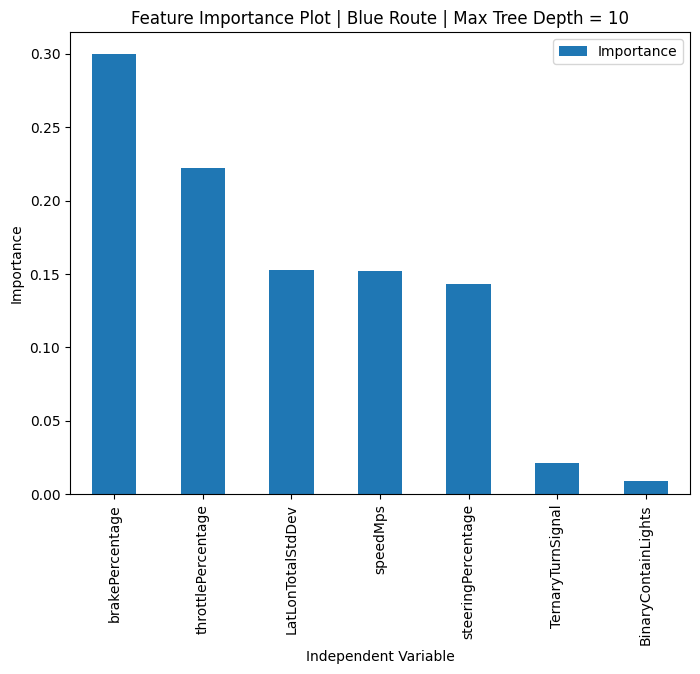

In [238]:
feat_importances = pd.DataFrame( model_dt_blue.feature_importances_, index = X_train_blue.columns, columns = [ "Importance" ] )

feat_importances.sort_values( by = 'Importance', ascending = False, inplace = True )

feat_importances.plot( kind = 'bar', figsize = ( 8, 6 ) )

plt.xlabel( 'Independent Variable' )

plt.ylabel( 'Importance' )

plt.title( 'Feature Importance Plot | Blue Route | Max Tree Depth = 10' )

plt.show()

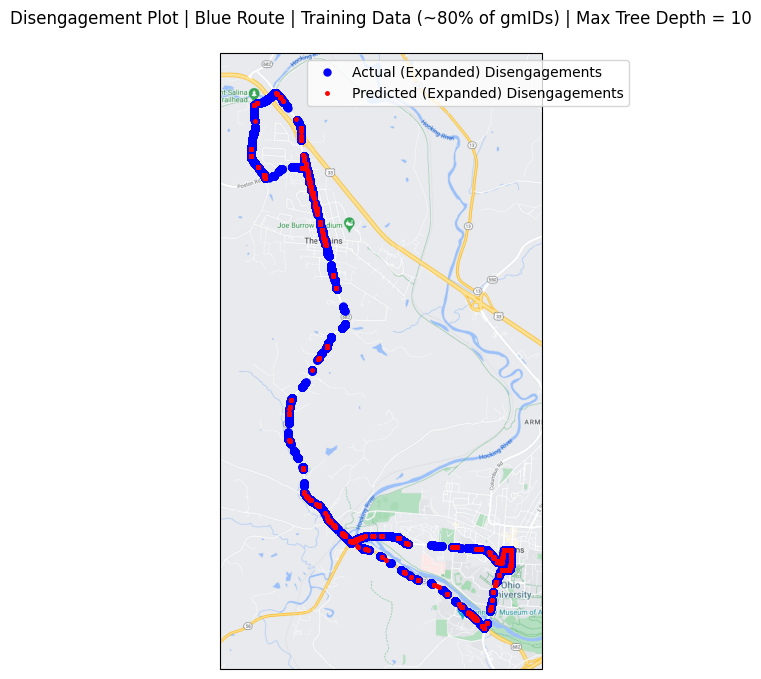

In [239]:
plt.figure( figsize = ( 8, 8 ) )

#

minLat = np.min( np.array( blue_df[ 'latitude' ] ) )

maxLat = np.max( np.array( blue_df[ 'latitude' ] ) )

minLon = np.min( np.array( blue_df[ 'longitude' ] ) )

maxLon = np.max( np.array( blue_df[ 'longitude' ] ) )

expansion_coeff = 0.005

#

street_map = GoogleTiles( style = 'street' )

ax = plt.axes( projection = street_map.crs )

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image(street_map, 14)

#

actual_disengagement_lat_list_test =  training_blue_df[ training_blue_df[ 'BinaryDisengagementExpanded' ] == '1' ][ 'latitude' ]

actual_disengagement_lon_list_test =  training_blue_df[ training_blue_df[ 'BinaryDisengagementExpanded' ] == '1' ][ 'longitude' ]

#

pred_disengagement_lat_list_test =  training_blue_df[ training_blue_df[ 'pred_BinaryDisengagementExpanded' ] == '1' ][ 'latitude' ]

pred_disengagement_lon_list_test =  training_blue_df[ training_blue_df[ 'pred_BinaryDisengagementExpanded' ] == '1' ][ 'longitude' ]

#

plt.plot( actual_disengagement_lon_list_test, 
          actual_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'blue',  
          ms = 5, 
          label = 'Actual (Expanded) Disengagements' )

plt.plot( pred_disengagement_lon_list_test, 
          pred_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'red', 
          ms = 2.5,
          label = 'Predicted (Expanded) Disengagements' )

plt.title( 'Disengagement Plot | Blue Route | Training Data (~80% of gmIDs) | Max Tree Depth = 10\n' )

plt.legend( bbox_to_anchor = ( .25, 1.0 ), loc = 'upper left' )

plt.show()

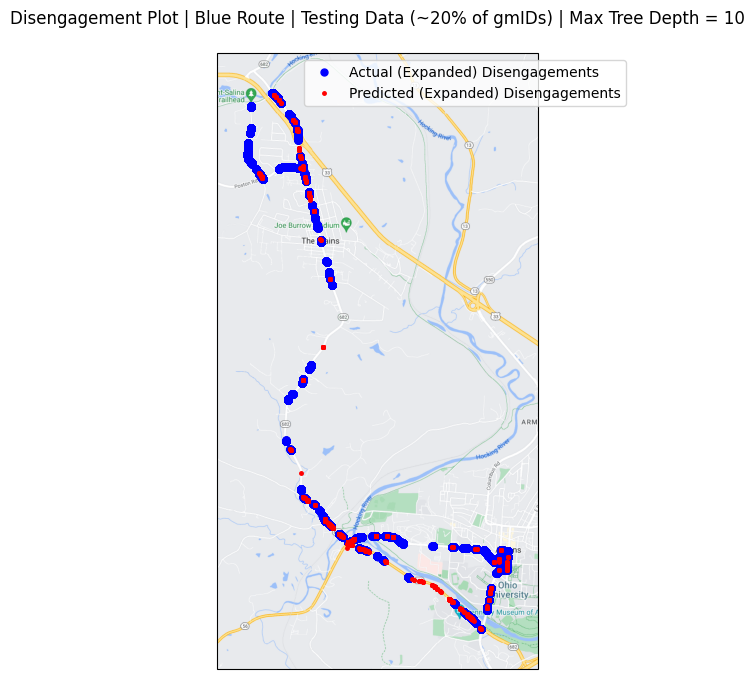

In [240]:
plt.figure( figsize = ( 8, 8 ) )

#

minLat = np.min( np.array( blue_df[ 'latitude' ] ) )

maxLat = np.max( np.array( blue_df[ 'latitude' ] ) )

minLon = np.min( np.array( blue_df[ 'longitude' ] ) )

maxLon = np.max( np.array( blue_df[ 'longitude' ] ) )

expansion_coeff = 0.005

#

street_map = GoogleTiles( style = 'street' )

ax = plt.axes( projection = street_map.crs )

ax.set_extent( [ minLon - expansion_coeff , maxLon + expansion_coeff, minLat - expansion_coeff, maxLat + expansion_coeff ], ccrs.PlateCarree() )

ax.add_image(street_map, 14)

#

actual_disengagement_lat_list_test =  testing_blue_df[ testing_blue_df[ 'BinaryDisengagementExpanded' ] == '1' ][ 'latitude' ]

actual_disengagement_lon_list_test =  testing_blue_df[ testing_blue_df[ 'BinaryDisengagementExpanded' ] == '1' ][ 'longitude' ]

#

pred_disengagement_lat_list_test =  testing_blue_df[ testing_blue_df[ 'pred_BinaryDisengagementExpanded' ] == '1' ][ 'latitude' ]

pred_disengagement_lon_list_test =  testing_blue_df[ testing_blue_df[ 'pred_BinaryDisengagementExpanded' ] == '1' ][ 'longitude' ]

#

plt.plot( actual_disengagement_lon_list_test, 
          actual_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'blue',  
          ms = 5, 
          label = 'Actual (Expanded) Disengagements' )

plt.plot( pred_disengagement_lon_list_test, 
          pred_disengagement_lat_list_test, 
          transform = ccrs.PlateCarree(), 
          marker = 'o', 
          ls = '', 
          color = 'red', 
          ms = 2.5,
          label = 'Predicted (Expanded) Disengagements' )

plt.title( 'Disengagement Plot | Blue Route | Testing Data (~20% of gmIDs) | Max Tree Depth = 10\n' )

plt.legend( bbox_to_anchor = ( .25, 1.0 ), loc = 'upper left' )

plt.show()

In [241]:
def equisplit_list( array_like_obj, num_of_groups, randomize_group_sizes_order = False ):

    array_like_obj_len = len( array_like_obj )

    #

    if ( num_of_groups > array_like_obj_len ):

        raise Exception( "'num_of_groups' must be less than or equal to length of 'array_like_obj'" )

    #

    group_size_approx =  array_like_obj_len // num_of_groups

    remainder = array_like_obj_len - group_size_approx * num_of_groups

    #

    group_sizes = [ group_size_approx for i in range( num_of_groups ) ]

    for group_num, group_size in enumerate( group_sizes ):

        if not ( remainder > 0 ):

            break

        group_sizes[ group_num ] = group_size + 1

        remainder = remainder - 1

    #

    indexes = [ index for index in range( array_like_obj_len ) ]

    if ( randomize_group_sizes_order == True ):

        random.shuffle( group_sizes )

    #

    group_end_indexes = list( np.cumsum( np.array( group_sizes ) ).astype( int ) )

    group_start_indexes = [ 0 ] + group_end_indexes[ : -1 ]

    group_indexes_list = [ indexes[ group_start_index : group_end_index ] for group_start_index, group_end_index \
                           in zip( group_start_indexes, group_end_indexes ) ]

    #

    equisplit_array_like_obj = []

    for group_indexes in group_indexes_list:

        equisplit_array_like_obj.append( [ val for i, val in enumerate( array_like_obj ) if i in group_indexes ] )

    #

    return equisplit_array_like_obj

def unique_traintest_combinations( array_like_obj, desired_train_percentage, display = False ):

    array_like_obj_len = len( array_like_obj )

    #

    indexes = [ index for index in range( array_like_obj_len ) ]

    #

    temp_array = np.array( [ np.abs( ( ( index + 1 ) / array_like_obj_len ) - desired_train_percentage ) for index in range( array_like_obj_len ) ] )

    split_index = np.argmin( temp_array )

    if ( split_index == array_like_obj_len - 1 ):

        split_index = split_index - 1

    #

    if ( display == True ):

        print( f'Actual Training Percentage: { ( ( split_index + 1 ) / array_like_obj_len ):.3f}' )

    #

    permutation_list = list( permutations( array_like_obj ) )

    list_of_potential_train_sets = list( set( [ frozenset( permutation[ : split_index + 1 ] ) for permutation in permutation_list ] ) )

    list_of_potential_test_sets = list( set( [ frozenset( permutation[ split_index + 1 : ] ) for permutation in permutation_list ] ) )

    #

    unique_traintest_combination_list = []

    for potential_train_set in list_of_potential_train_sets:

        for potential_test_set in list_of_potential_test_sets:

            if not potential_train_set.intersection( potential_test_set ):

                unique_traintest_combination_list.append( [ list( potential_train_set ), list( potential_test_set ) ] )

    #

    return unique_traintest_combination_list

def df_list_into_df_groups( df_list, num_of_groups, randomize_df_index_list = False, randomize_group_sizes_order = False ):

    df_list_len = len( df_list )

    df_index_list = [ index for index in range( df_list_len ) ] 

    #

    if ( randomize_df_index_list == True ):

        random.shuffle( df_index_list )

    #

    equisplit_df_index_list = equisplit_list( array_like_obj = df_index_list, \
                                              num_of_groups = num_of_groups, \
                                              randomize_group_sizes_order = randomize_group_sizes_order )

    #

    df_group_list = []

    for indexes in equisplit_df_index_list:

        df_group = pd.concat( [ df for index, df in enumerate( df_list ) if index in indexes ] )

    #

    return df_group_list